# American Stock Analysis
This project is aimed to get a specific company's financial statements of America from [U.S. Securities And Exchange Commission (SEC)](https://www.sec.gov/), including 
- Consolidated statements of operations (income statements)
- Consolidated statements of comprehensive income
- Consolidated balance sheet
- Consolidated statement of cash flows

Besides getting information about the company's financial statements, some important indicators such as ROA, gross margin, etc, are also calculated and the visualization of them is accomplished subsequently.

Financial statements of the targeted company is obtained from 10-K and 10-Q reports, searched from [EDGAR|Company Filings](https://www.sec.gov/edgar/searchedgar/companysearch).

Reference:
- [10-k財報怎麼看？美國財報閱讀入門教學](https://rich01.com/how-to-read-10k-for-beginners/)
- [How to Switch Tabs in Selenium For Python](https://www.browserstack.com/guide/how-to-switch-tabs-in-selenium-python)
- [What is close() and quit() commands in Selenium Webdriver?](https://www.zyxware.com/articles/5552/what-is-close-and-quit-commands-in-selenium-webdriver)
- [Python Stripytime](https://datagy.io/python-string-to-date/)
- [存金融股真的好嗎？投資人該知道金融股存股的好與壞](https://rich01.com/saving-finance-stock-risks-5/)
- [從財報、4指標篩優質銀行股](https://smart.businessweekly.com.tw/Reading/WebArticle.aspx?id=69258)
- [Regular expression operations #functions](https://docs.python.org/3/library/re.html#functions)
- [Inline XBRL 概念簡介](http://www.ais.nptu.edu.tw/ais/110_nccu/LectureNotes/inline%20XBRL%E6%A6%82%E5%BF%B5%E7%B0%A1%E4%BB%8B_20220205.pdf)
- [US GAAP與IFRS](https://davidhuang1219.pixnet.net/blog/post/335451785-%E7%BE%8E%E5%9C%8B%E5%85%AC%E8%AA%8D%E6%9C%83%E8%A8%88%E5%8E%9F%E5%89%87%EF%BC%88us-gaap%EF%BC%89vs-%E5%9C%8B%E9%9A%9B%E6%9C%83%E8%A8%88%E6%BA%96%E5%89%87)
- [Capital Adequacy Ratio (CAR)](https://corporatefinanceinstitute.com/resources/wealth-management/capital-adequacy-ratio-car/)
- [Non-Performing Loan (NPL)](https://corporatefinanceinstitute.com/resources/commercial-lending/non-performing-loan-npl/)

## Package used in this module

In [1]:
import requests
from bs4 import BeautifulSoup as BS
from bs4 import NavigableString
import time
from dateutil import parser
import re
from lxml import etree
import numpy as np
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys


import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import MultipleLocator

## Get data from sec.gov

In [2]:
# For test
# target_stock = "APPL"
# target_stock = "TSLA"
# target_stock = "KO"
# target_stock = "JNJ"
# target_stock = "哈哈ㄏ阿"
# target_stock = "GOOGL"  # Order data have smaller fact-identifier! Special case!
# target_stock = "MSFT"  # Special case in cash flows
# target_stock = "BAC"  # title is included in table!
# target_stock = "GS"
target_stock = input("Please enter stock name: ")


def get_source(target_stock):
    # Process 1: Get financial statements from SEC.gov
    # Visit "EDGAR | Company Filings" of SEC.gov to search for a targeted company
    print('Start connecting ...')
    browser = webdriver.Edge(r"msedgedriver.exe")    # Start webdriver.exe
    time.sleep(np.random.rand() + 2)    # Give 2.0 ~ 3.0 seconds for opening the webdriver.ext

    url_search = "https://www.sec.gov/edgar/searchedgar/companysearch"

    browser.get(url_search)
    time.sleep(np.random.rand() + 2)    # Give 2.0 ~ 3.0 seconds for loading web content from server

    # Find input element to enter the target stock abbreviation and press enter
    stock_input = browser.find_element(By.ID, "edgar-company-person")
    stock_input.send_keys(target_stock)
    time.sleep(np.random.rand() + 1)

    stock_input.send_keys(Keys.ENTER)
    time.sleep(np.random.rand() + 2)    # Hold 2 ~ 3 seconds for loading content from server



    # # Find the submit button to search for the result
    # submit = browser.find_element(By.CLASS_NAME, "collapsed-submit")

    # # Input the stock abbr. and submit
    # stock_input.send_keys(target_stock)
    # submit.click()


    # Click "View all 10-Ks and 10-Qs" button
    # If no matching companies is showed, then prompt retry message
    find_result_check = BS(browser.page_source, "html.parser").find('div', id='contentDiv')

    # if not re.search(r".*No matching companies\..*", find_result_check):
    # if not re.search(r".*No matching companies\..*", ):
    # if (not browser.find_element(By.XPATH, '//*[@id="contentDiv"]/div')):
    if not find_result_check:

        # Click "Selected Filings>>10-K (annual reports) and 10-Q (quarterly reports)"
        annual_quarterly_report = browser.find_element(By.XPATH, '//*[@id="filingsStart"]/div[2]/div[3]/h5')
        annual_quarterly_report.click()
        time.sleep(np.random.rand() + 1)    # Wait for 1 ~ 2 seconds
        
        # Click "View all 10-Ks and 10-Qs"
        all_KQs = browser.find_element(By.XPATH, '//*[@id="filingsStart"]/div[2]/div[3]/div/button[1]')
        all_KQs.click()
        
        # Add this part will cause reports clicked lack of 1? -> OK! .clear() method will automatically press enter key!
        # Clear reports' "From Date"
        from_date = browser.find_element(By.ID, "filingDateFrom")
        from_date.clear()
        time.sleep(np.random.rand() + 1)
#         from_date.send_keys(Keys.ENTER)
#         time.sleep(np.random.rand() + 3)
        
        
        
        # To get 9 quarterly report (including 10-K reports and 10-Q reports), first 8 files needs scanned
        reports = list()  # To store 8 HTMLs of financial statements
        company_name = browser.find_element(By.ID, "name").text

        # Get current window handle
        # Because when clicking the linkage of report, new tab will be created. 
        # Need to switch back to the original web page to get another report of different quarter.
        # current_window = browser.current_window_handle
        # print(current_window)

        # Parameters for requests
        user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36"
        headers = {'user-agent': user_agent}


        # Get first 8 10-K or 10-Q reports
        #try:
        # Count the amount of filed reports without duplication (Reporting date must be unique)

        # reports_count = 8 if len(browser.find_elements(By.XPATH, '//*[@id="filingsTable"]/tbody/tr')) >= 8 else len(browser.find_elements(By.XPATH, '//*[@id="filingsTable"]/tbody/tr'))
        reports_count = len(browser.find_elements(By.XPATH, '//*[@id="filingsTable"]/tbody/tr'))
        print('reports count: ', reports_count)


        # For test
        # xpath = '//*[@id="filingsTable"]/tbody/tr[1]/td[2]/div/a[1]'
        # report_link = browser.find_element(By.XPATH, xpath)
        # time.sleep(np.random.rand() + 1)
        # report_link.click()


        # A set to store reporting date
        reporting_date = set()


        # Open financial statements of search result from SEC.gov
        for i in range(reports_count):
            xpath_date = '//*[@id="filingsTable"]/tbody/tr[' + str(i + 1) + ']/td[4]/a'
            
            xpath = '//*[@id="filingsTable"]/tbody/tr[' + str(i + 1) + ']/td[2]/div/a[1]'
            
            check_amendment = re.compile(r"amendment")
            check_inability_to_timely_file = re.compile("inability to timely file")

            # APPL: //*[@id="filingsTable"]/tbody/tr[1]/td[4]/a
            # TSLA: //*[@id="filingsTable"]/tbody/tr[1]/td[4]/a
            #     # Record current window ID for switching between tabs of browser
            #     reports_window = browser.current_window_handle

            # args = (By.XPATH, xpath)

            if(len(reporting_date) < 9):
                if(not check_amendment.search(browser.find_element(By.XPATH, xpath).text) and not check_inability_to_timely_file.search(browser.find_element(By.XPATH, xpath).text)):
                    reporting_date.add(browser.find_element(By.XPATH, xpath_date).text)
                    report_link = browser.find_element(By.XPATH, xpath)
                    time.sleep(np.random.rand() + 1.5)
                    report_link.click()
                    time.sleep(np.random.rand() + 2)

                else:
                    continue


            elif(len(reporting_date) >= 9):
                break
            else:
                print("Something wrong when clicking report link!")
                break




        # Get HTMLs from web tabs
        # Record new tab of window ID, string type
        new_windows = browser.window_handles

        # Get current window handle
        current_window = browser.current_window_handle

        for window in new_windows:
            if(window != current_window):
                browser.switch_to.window(window)
                time.sleep(np.random.rand() + 1.5)
                report = BS(browser.page_source, "html.parser")
                url = browser.current_url
                #date_match = re.search(r"([-_]\d{8}).*\.htm$", url)

                # (BeautifulSoup object, url, date)
#                 date = None
#                 if not date_match:
#                     date = parser.parse(report.find(name = "ix:nonnumeric", attrs = {"name" : "dei:DocumentPeriodEndDate"}).text)
#                 else:
#                     date = parser.parse(date_match.group(1))
                    
                date = parser.parse(report.find(name = "ix:nonnumeric", attrs = {"name" : "dei:DocumentPeriodEndDate"}).text  if report.find(name = "ix:nonnumeric", attrs = {"name" : "dei:DocumentPeriodEndDate"}) else list(reporting_date)[new_windows.index(window) - 1])
                reports.append((report, url, date))







        """
        # This section is bulit elsewhere. It will be replaced after the program of this part is completed.
        # Process 2: Extract financial statements from the collected HTMLs
        # Format settings of dataframe
        report_data = []
        report_index = []
        report_column = []

        for report in reports:
            print(type(report))

        # Differnt type of stocks (company and financial industry)
        # Financial industry has no inventories. It's a industry earning money by money! Different measurement needs to be implyed.
        """



    else:
        print('Execute else statement ...') 
        print('No matching companies. Please try again.')



    # except:
        #print('Can not get 10-K or 10-Q reports from SEC.gov!')
    # finally:
    #     pass
    #     browser.close()
    print("End connecting ...")
    browser.quit()  # Close the webdriver.exe  
    return (reports, company_name)





reports, company_name = get_source(target_stock)
# print()

Please enter stock name: jpm
Start connecting ...
reports count:  32
End connecting ...


In [3]:
len(reports)
# print(reports_count)

9

In [4]:
company_name

'JPMORGAN CHASE & CO'

In [5]:
for repo in reports:
    print(repo[2])

2021-03-31 00:00:00
2021-06-30 00:00:00
2021-09-30 00:00:00
2021-12-31 00:00:00
2022-03-31 00:00:00
2022-09-30 00:00:00
2022-12-31 00:00:00
2022-06-30 00:00:00
2023-03-31 00:00:00


## Function definition

In [6]:
# Check the report type (10-K or 10-Q)
def check_report_type(soup):
    # print(str(soup))
    #test_list = soup.find_all("ix:nonnumeric", {"id" : re.compile(r"fact-identifier-\d+")})
    test_list = soup.find_all("ix:nonnumeric", {"name" : "dei:DocumentType"})
    # print(test)
    # test = etree.HTML(str(soup)).xpath('//*[@id="dynamic-xbrl-form"]/div[10]/table/tbody/tr[2]/td[2]/span')[0].text
    
    
    # 片立每個test才能決定是哪個報表!!
    if(any(test.string == "10-Q" for test in test_list)):
        return 'Q'
    elif(any((test.string == "10-K")for test in test_list)):
        return 'K'
    else:
        return "Drop"


# Different companies have different scale of industry -> Not all monetary unit is i"in million"! -> Depends on "scale"
def transform_to_number(soup):
    number = 0
    if soup:
        # print(soup.text.replace(',', ''))
        number = float(soup.text.replace(',', '')) if soup.text != '—' else 0
        #number *= np.power(10, (float(soup["scale"]) - 6)) if (soup["decimals"] != "2") else 1
        number *= np.power(10, (float(soup["scale"]))) if soup.has_attr("scale") else 1
        number = number if ((soup.has_attr("isnegativesonly") and soup["isnegativesonly"] == "false") or (not soup.has_attr("isnegativesonly") and not re.search("\(.*\)",soup.parent.parent.text))) else -number
    else:
        number = np.nan
        
    #print("transformed number: ", number)
    return number


# Get data from table
def extract_data(tables, pattern, iscalculationsonly, position):
    
    # table: The source of data
    # pattern: The pattern of "name" tag. Different data have their own patterns
    # iscalculationsonly: Feature to further focus on the targeted tag of data
    # position: The position of the targeted data
    
    temp_list = []
    for table in tables:
        if iscalculationsonly:
            temp_list.extend(table.find_all(name = "ix:nonfraction", attrs = {"name" : re.compile(pattern), "iscalculationsonly" : re.compile(iscalculationsonly)}))
        else:
            temp_list.extend(table.find_all(name = "ix:nonfraction", attrs = {"name" : re.compile(pattern)}))
    
    data_tag = sorted(temp_list, key = lambda x : int(re.search(r"\d+", x.get("id")).group(0)))[position] if len(temp_list) - 1 >= position else None
    #print(data_tag)
    data = transform_to_number(data_tag)
    temp_list.clear()
#     table.clear()
    return data
    
#     if(isinstance(position, int)):
#         data_tag = sorted(temp_list, key = lambda x : int(re.search(r"\d+", x.get("id")).group(0)))[position] if len(temp_list) - 1 >= position else None
#         data = transform_to_number(data_tag)
#         temp_list.clear()
#     #     table.clear()
#         return data
    
#     elif(isinstance(position, str)):
#         if(position == "GET_MAX"):
#             data_tags = sorted(temp_list, key = lambda x : int(re.search(r"\d+", x.get("id")).group(0))) if len(temp_list) - 1 > 0 else None
#             datas = [transform_to_number(data_tag) for data_tag in data_tags]
#             data = max(datas)
#             return data
#         else:
#             pass
#     else:
#         print("Unknown parameter")
#         return None
    

def check_industry_type(soup):
    test_list = soup.find_all("ix:nonfraction", {"name" : re.compile(r"^us-gaap:InventoryNet$"), "iscalculationsonly" : "true"})
    
    if(len(test_list) == 0):
        return "F"
    elif(len(test_list) > 0):
        return "N"
    else:
        print("Unknown industry type")
        return "U"

# Visualization of data

## Check industry type

In [7]:
# Check industry type
# Special case: META(no inventory, but not financial industry) -> No problem when plotting, so that's OK
industry_type = check_industry_type(reports[0][0])
industry_type

'F'

## Find common portion of financial reports from SEC.gov
### For non-financial industry
- CONSOLIDATED STATEMENTS OF INCOME (from coca cola, 10-Q/1)
- CONSOLIDATED BALANCE SHEETS (from coca cola, 10-Q/1)
- CONSOLIDATED STATEMENTS OF CASH FLOWS (from coca cola, 10-Q/1)
- CONSOLIDATED STATEMENTS OF INCOME (from coca cola, 10-Q/3)

- CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited) (from Apple, 10-Q/1)
- CONDENSED CONSOLIDATED BALANCE SHEETS (Unaudited) (from Apple, 10-Q/1)
- CONDENSED CONSOLIDATED STATEMENTS OF CASH FLOWS (Unaudited) (from Apple, 10-Q/1)

- Consolidated Balance Sheets (from Tesla, 10-Q/1)
- Consolidated Balance Sheets (from Tesla, 10-K/2021)
- Consolidated Statements of Operations (from Tesla, 10-Q/1)
- Consolidated Statements of Cash Flows (from Tesla, 10-Q/1)

Looks like there are some common titles in different company's financial statements (regardless of upper-case or lower-case)


**Get the report's date:**
- In <ix:nonnumeric> tag. But different format were found! (All in the tag or nested in tag). No format could be found!!
- Get reporting date from url!! -> OK

**Find table of three main financial statements:**
- After found the place of targeted title, find the nearest table. It might be the targeted table.


**Pattern of three basic financial statements :**</br>
CONSOLIDATED STATEMENTS OF INCOME (or Consolidated Statements of Operations):
- 10-Q
    - First column after title column is needed (exact earning/loss monetary value of the specific quarter)
    - First \$: First monetary value appears
    - Second \$: Net income
    - No fixed position of each items
    - <font color="red">Check ix tag properties</font>: nonfraction(accounting items), name(prefix = us-gaap, term in this property can be referenced), isnegativesonly(determine the number is +/-), iscalculationsonly(true: wanted for calculation)
    - How to get the data of corrected date? Using <font color="chocolate">name & iscalculationsonly & isnegativesonly</font> to find a list of numbers, then sort it by id. Smaller one cprresponds to the newer date of data.
    - 
- 10-K
    - Same as analysis of 10-Q reports!
    
Other two basic financial statements have same pattern!</br>

**Items wanted to be calculated:**</br>
* Quarter date (as columns)
* Assets
* Inventory
* Liabilities
* Total stockholder's equity
* Earning per share basic/diluted
* Revenue
* Gross profit
* Earning before provision for taxes on income
* Net income (Income after taxes)
* Comprehensive income net of tax (net income + other comprehensive income)
* Net cash provided by operating activities
* Net cash used in investing activities
* Net cash used in financing activities

In [13]:
# For executing this module first time, please execute the above program first, then "reports" are obtained.
# Build program of section 2 -> OK!
# Extract data from reports
# Need to consider some special case. Like GOOGLE

def extract_from_reports(reports, industry_type, special_case = None):
    
    #Default settings
    #Filter tag functions
#     def find_table_operations(tag):
#         if(tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
#             return True
#         return False
    
#     def find_table_comprehensive(tag):
#         if(tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
#             return True
#         return False
    
#     def find_table_balance(tag):
#         if(tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
#             return True
#         return False
    
#     def find_table_cashflow(tag):
#         if(tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
#             return True
#         return False
    
#     def find_table_credit(tag):
#         if(tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
#             return True
#         return False
    
    
    
#     def find_table_balance_nested(tag):
#         #print("Overwrite success!")
#         if(tag.name == "table" and any((element.name == "span" and title_regex.search(element.text)) for element in tag.descendants)):
#             return True
#         return False

#     def find_table_operations_nested(tag):
#         #print("Overwrite success!")
#         if(tag.name == "table" and any((element.name == "span" and title_regex.search(element.text)) for element in tag.descendants)):
#             return True
#         return False

#     def find_table_comprehensive_nested(tag):
#         #print("Overwrite success!")
#         if(tag.name == "table" and any((element.name == "span" and title_regex.search(element.text)) for element in tag.descendants)):
#             return True
#         return False

#     def find_table_cashflow_nested(tag):
#         #print("Overwrite success!")
#         if(tag.name == "table" and any((element.name == "span" and title_regex.search(element.text)) for element in tag.descendants)):
#             return True
#         return False

#     def find_table_credit_nested(tag):
#         if(tag.name == "table" and any((element.name == "span" and title_regex.search(element.text)) for element in tag.descendants)):
#             return True
#         return False
    
#     def find_table_risk_weighted_assets_nested(tag):
#         if(tag.name == "table" and any((element.name == "span" and title_regex.search(element.text)) for element in tag.descendants)):
#             return True
#         return False
   
#     def find_risk_weighted_assets(tag):
#         #if(tag.name = "span" and tag.parent.)
#         pass

#     # Title patterns
#     title_pattern_balance = "[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [bB][aA][lL][aA][nN][cC][eE] [sS][hH][eE][eE][tT][sS]?"
#     title_pattern_comprehensive = "[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS]? [oO][fF] [cC][oO][mM][pP][rR][eE][hH][eE][nN][sS][iI][vV][eE] [iI][nN][cC][oO][mM][eE]"
#     title_pattern_operations = "[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS]? [oO][fF] [oO][pP][eE][rR][aA][tT][iI][oO][nN][sS]|[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS]? [oO][fF] [iI][nN][cC][oO][mM][eE]|[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS]? [oO][fF] [eE][aA][rR][nN][iI][nN][gG][sS]|[cC][oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [iI][nN][cC][oO][mM][eE] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS]?"
#     title_pattern_cashflow = "[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS]? [oO][fF] [cC][aA][sS][hH] [fF][lL][oO][wW][sS]?|[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [cC][aA][sS][hH] [fF][lL][oO][wW][sS]? [sS][tT][aA][tT][eE][mM][eE][nN][tT][sS]?"
#     title_pattern_credit = "^[cC][rR][eE][dD][iI][tT] [qQ][uU][aA][lL][iI][tT][yY]"
#     title_pattern_risk_weighted_assets = "^Risk-weighted [aA]ssets"

    
    # Datas' position
    position = (0, 2, 0)  # (current quarter, previous quarter, fiscal year)
    position_income = (0, 2, 0)
    position_comprehensive = (0, 2, 0)
    position_nonperforming_loans = 0
    position_cash_flow = (0, 0, 0)  # (current quarter, previous quarter, fiscal year)
#     iscalculationsonly_revenue = "true"
    
    
    # Flags related to financial statement's structure
    CASHFLOW_QUARTER_NEED_COUNT = True
#     TITLE_NESTED_IN_TABLE = False
    DONT_FIND_TABLE = True
#     RISK_WEIGHTED_ASSETS_NOT_IN_TABLE = False
    
    
    # Don't use match-case (only supported above 3.10.x)
    """ 
    match special_case:
        case "Alphabet Inc.":
            position = (1, 3, 2)
            position_cash_flow = (1, 1, 2)
            iscalculationsonly_revenue = "true|false"
        case _:
            pass
    """
    
    # Special case params
    # Special case params
    if(special_case == "Alphabet Inc."):
        position = (1, 3, 2)
        position_cash_flow = (1, 1, 2)
        iscalculationsonly_revenue = "true|false"
        
    elif(special_case == "MICROSOFT CORP"):
        title_pattern_balance = r"^BALANCE SHEETS\s?$"
        title_pattern_operations = r"^INCOME STATEMENTS\s?$"
        title_pattern_comprehensive = r"^COMPREHENSIVE INCOME STATEMENTS\s?$"
        title_pattern_cashflow = r"^CASH FLOWS STATEMENTS\s?$"
        
        position_cash_flow = (0, 2, 0)  # (current quarter, previous quarter, fiscal year)
        CASHFLOW_QUARTER_NEED_COUNT = False
        
#         def find_table_balance(tag):
#             #print("Overwrite success!")
#             if(tag.name == "p" and title_regex.search(tag.text)):
#                 return True
#             return False
        
#         def find_table_operations(tag):
#             #print("Overwrite success!")
#             if(tag.name == "p" and title_regex.search(tag.text)):
#                 return True
#             return False
        
#         def find_table_comprehensive(tag):
#             #print("Overwrite success!")
#             if(tag.name == "p" and title_regex.search(tag.text)):
#                 return True
#             return False
        
#         def find_table_cashflow(tag):
#             #print("Overwrite success!")
#             if(tag.name == "p" and title_regex.search(tag.text)):
#                 return True
#             return False
        
    elif(special_case == "BANK OF AMERICA CORP /DE/"):
        
        # Table's title is included in targeted table 
#         TITLE_NESTED_IN_TABLE = True
        
        position_nonperforming_loans = -2
        
    elif(special_case == "Monster Beverage Corp"):
        pass
#         title_pattern_balance = "CONSOLIDATED BALANCE SHEETS$"
#         def find_table_balance(tag):
#             if(tag.name == "p" and title_regex.search(tag.text)):
#                 return True
#             return False
        
#         title_pattern_operations = "CONSOLIDATED STATEMENTS OF INCOME$"
#         def find_table_operations(tag):
#             if(tag.name == "p" and title_regex.search(tag.text)):
#                 return True
#             return False
        
#         title_pattern_comprehensive = "CONSOLIDATED STATEMENTS OF COMPREHENSIVE INCOME$"
#         def find_table_comprehensive(tag):
#             if(tag.name == "p" and title_regex.search(tag.text)):
#                 return True
#             return False
        
#         title_pattern_cashflow = "CONSOLIDATED STATEMENTS OF CASH FLOWS$"
#         def find_table_cashflow(tag):
#             if(tag.name == "p" and title_regex.search(tag.text)):
#                 return True
#             return False

    elif(special_case == "KIMBERLY CLARK CORP"):
        pass
    
    elif(special_case == "CLOROX CO /DE/"):
        print("No 10-K financial statements provided. Do not extract data of this company!")
        return None
    
    elif(special_case == "CHURCH & DWIGHT CO INC /DE/"):
        pass
#         title_pattern_balance = "[oO][nN][sS][oO][lL][iI][dD][aA][tT][eE][dD] [bB][aA][lL][aA][nN][cC][eE] [sS][hH][eE][eE][tT][sS]$"
#         def find_table_balance(tag):
#             if(re.search("p|span", tag.name) and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
#                 return True
#             return False
        
#         def find_table_operations(tag):
#             if(re.search("p|span", tag.name) and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
#                 return True
#             return False
        
#         def find_table_cashflow(tag):
#             if(re.search("p|span", tag.name) and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
#                 return True
#             return False
    
    elif(special_case == "GENERAL MILLS INC"):
        
#         title_pattern_operations = "^Consolidated Statements of Earnings\s?$"
#         def find_table_operations(tag):
#             if(re.search("div|span", tag.name) and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString):
#                 return True
#             return False
        
        # Some titles are nested in tables, some even have no tables containing data (after 2022-5-29)!
#         TITLE_NESTED_IN_TABLE = True
        pass
    
    elif(special_case == "BEYOND MEAT, INC."):
        pass
#         TITLE_NESTED_IN_TABLE = True
      
    elif(special_case == "Philip Morris International Inc."):
        position_income = (2, 0, 0)
        position_comprehensive = (2, 0, 0)
        
    elif(special_case == "CONSTELLATION BRANDS, INC."):
        position_income = (2, 0, 0)
        position_comprehensive = (2, 0, 0)
    
    else:
        # Normal report structure
        pass
    
    
    
    
    # Sort reports by its date, also filter out unwanted reports
    reports_filtered = filter(lambda report : report[2] is not None, reports)
    #print(type(reports_filtered))
    reports_sorted = sorted(reports_filtered, key = lambda report : report[2])  # Sorted by date, ascending
    #print("reports count: ", str(len(reports_sorted)))

    # for report in reports_sorted:
    #     print(report[1])  # url, string
    #     print(report[2])  # Date object
    #     print(check_report_type(report[0]))  #report[0]: BS object



   
    # In case that financial statement may be divided into two tables, all the eligible title spans need to be founded
    # Find table for "Consolidated statements of operations (incomes)"
    table_operations = []
    for report in reports_sorted:
#         title_regex = re.compile(title_pattern_operations)
        
#         if not TITLE_NESTED_IN_TABLE:
            
#             # title_span = report[0].find("span", text = title_regex)
#             title_spans = report[0].find_all(find_table_operations)
#             #title_spans = report[0].find_all(lambda tag : tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString)
#             tables = [title_span.findNext("table") for title_span in title_spans] # No matter the element is nested or not, just find the conformed element sequentially
#             tables = report[0] if not tables else tables
#             print("Income: ", len(tables))
#             table_operations.append((title_spans, tables, report[2]))  
#         else:
#             tables = report[0].find_all(find_table_operations_nested)
#             tables = report[0] if not tables else tables
#             print("Nested Income: ", len(tables))
#             table_operations.append((None, tables, report[2])) 
            
        if DONT_FIND_TABLE:
#             table_operations.pop()
            table_operations.append((None, report[0], report[2]))



    # print(table_operations[7][1])


    # Find table for "Consolidated statements of comprehensive income"
    table_comprehensive_income = []
    for report in reports_sorted:
#         title_regex = re.compile(title_pattern_comprehensive)
        
#         if not TITLE_NESTED_IN_TABLE:
#             # title_span = report[0].find("span", text = title_regex)
#             #title_spans = report[0].find_all(lambda tag : tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString)

#             title_spans = report[0].find_all(find_table_comprehensive)
#             tables = [title_span.findNext("table") for title_span in title_spans] # No matter the element is nested or not, just find the conformed element sequentially
#             tables = report[0] if not tables else tables
#             print("Comprehensive: ", len(tables))
#             table_comprehensive_income.append((title_spans, tables, report[2])) 
#         else:
#             tables = report[0].find_all(find_table_comprehensive_nested)
#             tables = report[0] if not tables else tables
#             print("Nested Comprehensive: ", len(tables))
#             table_comprehensive_income.append((None, tables, report[2])) 
            
            
        if DONT_FIND_TABLE:
#             table_comprehensive_income.pop()
            table_comprehensive_income.append((None, report[0], report[2]))



    # print(table_comprehensive_income[7][1])


    # Find table for "Consolidated balance sheets"
    table_balances = []
    for report in reports_sorted:
#         title_regex = re.compile(title_pattern_balance)
        
#         if not TITLE_NESTED_IN_TABLE:
#             # title_span = report[0].find("span", text = title_regex)
#             #title_spans = report[0].find_all(lambda tag : tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString)

#             title_spans = report[0].find_all(find_table_balance)

#             tables = [title_span.findNext("table") for title_span in title_spans]  # No matter the element is nested or not, just find the conformed element sequentially
#             tables = report[0] if not tables else tables
#             print("Balance: ", len(tables))
#             table_balances.append((title_spans, tables, report[2]))  
#         else:
#             tables = report[0].find_all(find_table_balance_nested)
#             tables = report[0] if not tables else tables
#             print("Nested Balance: ", len(tables))
#             table_balances.append((None, tables, report[2]))  
            
        if DONT_FIND_TABLE:
#             table_balances.pop()
            table_balances.append((None, report[0], report[2]))


    # print(table_balances[2][1])



    # Find table of "Consolidated statements of cash flows"
    table_cashflows = []
    for report in reports_sorted:
#         title_regex = re.compile(title_pattern_cashflow)
        
#         if not TITLE_NESTED_IN_TABLE:
#             # title_span = report[0].find("span", text = title_regex)
#             #title_spans = report[0].find_all(lambda tag : tag.name == "span" and title_regex.search(tag.text) and type(tag.contents[0]) is NavigableString)

#             title_spans = report[0].find_all(find_table_cashflow)

#             tables = [title_span.findNext("table") for title_span in title_spans]  # No matter the element is nested or not, just find the conformed element sequentially
#             tables = report[0] if not tables else tables
#             print("Cashflows: ", len(tables))
#             table_cashflows.append((title_spans, tables, report[2]))  
#         else:
#             tables = report[0].find_all(find_table_cashflow_nested)
#             tables = report[0] if not tables else tables
#             print("Nested Cashflows: ", len(tables))
#             table_cashflows.append((None, tables, report[2]))  
            
            
        if DONT_FIND_TABLE:
#             table_cashflows.pop()
            table_cashflows.append((None, report[0], report[2]))


    # print(table_cashflows[2][1])
    
    
    # Find table of "Credit quality" (for financial industry)
    table_credit_quality = []
    for report in reports_sorted:
#         title_regex = re.compile(title_pattern_credit)
#         if not TITLE_NESTED_IN_TABLE:
#             title_spans = report[0].find_all(find_table_credit)

#             tables = [title_span.findNext("table") for title_span in title_spans]  # No matter the element is nested or not, just find the conformed element sequentially
#             tables = report[0] if not tables else tables
#             print("Credit: ", len(tables))
#             table_credit_quality.append((title_spans, tables, report[2])) 
#         else:
#             tables = report[0].find_all(find_table_credit_nested)
#             tables = report[0] if not tables else tables
#             print("Nested Credit: ", len(tables))
#             table_credit_quality.append((None, tables, report[2]))  
            
        if DONT_FIND_TABLE:
#             table_credit_quality.pop()
            table_credit_quality.append((None, report[0], report[2]))


    # Find table of "Risk-weighted assets"
    table_risk_weighted_assets = []
    for report in reports_sorted:
#         title_regex = re.compile(title_pattern_risk_weighted_assets)
#         tables = report[0].find_all(find_table_risk_weighted_assets_nested)
#         tables = report[0] if not tables else tables
#         print("Nested Risk-weighted: ", len(tables))
#         table_risk_weighted_assets.append((None, tables, report[2])) 
        
        
        if DONT_FIND_TABLE:
#             table_risk_weighted_assets.pop()
            table_risk_weighted_assets.append((None, report[0], report[2]))

    
    # Extract the targeted data from the above tables, quarter by quarter, depends on industry type
    print("Start processing data ...")
    if(industry_type == "N"):
        # Settings of pandas's dataframe
        
        result_columns = []  # Quarter date
        result_index = ["Assets", "Inventories", "Liabilities", "Total stockholder's equity", "Earning per share basic", "Earning per share diluted",
                     "Revenue", "Gross profit", "Earning before provision for taxes on income", "Net income", "Comprehensive income net of tax",
                     "Net cash from operating activities", "Net cash from investing activities", "Net cash from financing activities",
                     "Gross margin (%)", "Operating margin (%)", "Net income margin (%)", "Days Inventory (days)",
                     "Return on assets (%)", "Return on equity (%)"]
        result_data = [[0] * (len(reports) - 1) for _ in range(len(result_index))]
        print(len(reports_sorted))





        # Extract data from the above tables version 2
        # Probably no 9 reports will be gotten!
        for i in range(1, len(reports)):
            # Add quarter date
            result_columns.append(reports_sorted[i][2].date())


            # Get assets
            result_data[0][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:Assets$", None, position[0])


            # Get inventories
            result_data[1][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:InventoryNet$", None, position[0])


            # Get liabilities (May need to be calculated!)
            result_data[2][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:Liabilities$", None, position[0])



            # Get total stockholder's equity (May need to be calculated!)
            result_data[3][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:StockholdersEquity$", None, position[0])


            # Calculate liabilities or stockholder's equity

            for j in range(8):
                if(not np.isnan(result_data[0][j]) and np.isnan(result_data[2][j]) and not np.isnan(result_data[3][j])):
                    result_data[2][j] = result_data[0][j] - result_data[3][j]
                elif(not np.isnan(result_data[0][j]) and not np.isnan(result_data[2][j]) and np.isnan(result_data[3][j])):
                    result_data[3][j] = result_data[0][j] - result_data[2][j]
                else:
                    pass

            # Calculate liabilities or stockholder's equity
            """
            if(not np.isnan(result_data[0][i - 1]) and np.isnan(result_data[2][i - 1]) and not np.isnan(result_data[3][i - 1])):
                result_data[2][i - 1] = result_data[0][i - 1] - result_data[3][i - 1]
            elif(not np.isnan(result_data[0][i - 1]) and not np.isnan(result_data[2][i - 1]) and np.isnan(result_data[3][i - 1])):
                result_data[3][i - 1] = result_data[0][i - 1] - result_data[2][i - 1]
            else:
                pass
            """



            # Difference between 10-K and 10-Q reports
            if(check_report_type(reports_sorted[i][0]) == "Q"):

                # Get EPS (basic)
                result_data[4][i - 1] = np.round(extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareBasic$|^us-gaap:IncomeLossFromContinuingOperationsPerBasicShare$", None, position_income[0]), 2)

                # Get EPS (diluted)
                result_data[5][i - 1] = np.round(extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareDiluted$|^us-gaap:IncomeLossFromContinuingOperationsPerDilutedShare$", None, position_income[0]), 2)

                # Get revenues
                #print("Revenue")
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:Revenue", "true", position_income[0])):                    
                    result_data[6][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:Revenue", "true", position_income[0])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:Revenue", None, position_income[0])):
                    result_data[6][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:Revenue", None, position_income[0])
                else:
                    result_data[6][i - 1] = np.nan
                



                # Get gross profit (May need to be calculated)
                cost_of_revenue = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", "true", position_income[0])):
                    cost_of_revenue = extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", "true", position_income[0])  
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", None, position_income[0])):
                    cost_of_revenue = extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", None, position_income[0])
                else:
                    pass
                
                
                gross_profit = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position_income[0])):
                    gross_profit = extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position_income[0])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", None, position_income[0])):
                    gross_profit = extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", None, position_income[0])
                else:
                    pass
                
                if not np.isnan(gross_profit):
                    result_data[7][i - 1] = gross_profit
                elif not np.isnan(result_data[6][i - 1]) and not np.isnan(cost_of_revenue):
                    result_data[7][i - 1] = result_data[6][i - 1] - cost_of_revenue
                else:
                    result_data[7][i - 1] = np.nan
                    

                # Get Income before provision for income taxes
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", "true", position_income[0])):
                    result_data[8][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", "true", position_income[0])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", None, position_income[0])):
                    result_data[8][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", None, position_income[0])
                else:
                    result_data[8][i - 1] = np.nan
                    
                    

                # Get net income
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", "true", position_comprehensive[0])):
                    result_data[9][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", "true", position_comprehensive[0])                
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", None, position_comprehensive[0])):
                    result_data[9][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", None, position_comprehensive[0])    
                else:
                    result_data[9][i - 1] = np.nan


                # Get comprehensive income net of tax
                if not np.isnan(extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", "true", position_comprehensive[0])):
                    result_data[10][i - 1] = extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", "true", position_comprehensive[0])
                elif not np.isnan(extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", None, position_comprehensive[0])):
                    result_data[10][i - 1] = extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", None, position_comprehensive[0])
                else:
                    result_data[10][i - 1] = np.nan

            elif(check_report_type(reports_sorted[i][0]) == "K"):

                # Get EPS (basic)
                result_data[4][i - 1] = np.round(extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareBasic$|^us-gaap:IncomeLossFromContinuingOperationsPerBasicShare$", None, position_income[2]), 2)

                # Get EPS (diluted)
                result_data[5][i - 1] = np.round(extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareDiluted$|^us-gaap:IncomeLossFromContinuingOperationsPerDilutedShare$", None, position_income[2]), 2)


                # Get revenues (Need to get data from the previous quarter report, then calculate it)
                # 1. Get nine months accumulated data
                previous_revenues = np.nan
                if not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:Revenue", "true", position_income[1])):
                    previous_revenues = extract_data(table_operations[i - 1][1], r"^us-gaap:Revenue", "true", position_income[1])
                elif not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:Revenue", None, position_income[1])):
                    previous_revenues = extract_data(table_operations[i - 1][1], r"^us-gaap:Revenue", None, position_income[1])
                else:
                    pass


                # 2. Get revenues of whole fiscal year
                year_revenues = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:Revenue", "true", position_income[2])):
                    year_revenues = extract_data(table_operations[i][1], r"^us-gaap:Revenue", "true", position_income[2])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:Revenue", None, position_income[2])):
                    year_revenues = extract_data(table_operations[i][1], r"^us-gaap:Revenue", None, position_income[2])
                else:
                    pass

                # 3. Calculate revenue from the above values
                if not np.isnan(year_revenues) and not np.isnan(year_revenues):
                    result_data[6][i - 1] = year_revenues - previous_revenues
                else:
                    result_data[6][i - 1] = np.nan
                
                
                #print("Revenue calculated!")
                #print("year_revenues: ", year_revenues)
                #print("previous_revenues: ", previous_revenues )


                # Get gross profit (Need to get data from the previous quarter report, then calculate it)
                previous_gross_profit = np.nan
                if not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:GrossProfit$", "true", position_income[1])):
                    previous_gross_profit = extract_data(table_operations[i - 1][1], r"^us-gaap:GrossProfit$", "true", position_income[1])
                elif not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:GrossProfit$", None, position_income[1])):
                    previous_gross_profit = extract_data(table_operations[i - 1][1], r"^us-gaap:GrossProfit$", None, position_income[1])
                else:
                    pass
                
                
                year_gross_profit = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position_income[2])):
                    year_gross_profit = extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position_income[2])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", None, position_income[2])):
                    year_gross_profit = extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", None, position_income[2])
                else:
                    pass
                
                gross_profit = np.nan
                if not np.isnan(year_gross_profit) and not np.isnan(previous_gross_profit):
                    gross_profit = year_gross_profit - previous_gross_profit
                else:
                    pass

                previous_cost_of_revenue = np.nan
                if not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", "true", position_income[1])):
                    previous_cost_of_revenue = extract_data(table_operations[i - 1][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", "true", position_income[1])
                elif not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", None, position_income[1])):
                    previous_cost_of_revenue = extract_data(table_operations[i - 1][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", None, position_income[1])
                else:
                    pass
                
                year_cost_of_revenue = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", "true", position_income[2])):
                    year_cost_of_revenue = extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", "true", position_income[2])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", None, position_income[2])):
                    year_cost_of_revenue = extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$|^us-gaap:CostOfGoodsAndServicesSold$", None, position_income[2])
                else:
                    pass
                
                
                cost_of_revenue = np.nan
                if not np.isnan(year_cost_of_revenue) and not np.isnan(previous_cost_of_revenue):                
                    cost_of_revenue = year_cost_of_revenue - previous_cost_of_revenue
                else:
                    pass

                if not np.isnan(gross_profit):
                    result_data[7][i - 1] = gross_profit
                elif not np.isnan(result_data[6][i - 1]) and not np.isnan(cost_of_revenue):
                    result_data[7][i - 1] = result_data[6][i - 1] - cost_of_revenue
                else:
                    result_data[7][i - 1] = np.nan



                # Get Income before provision for income taxes
                previous_income_before_tax = np.nan
                if not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", "true", position_income[1])):
                    previous_income_before_tax = extract_data(table_operations[i - 1][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", "true", position_income[1])
                elif not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", None, position_income[1])):
                    previous_income_before_tax = extract_data(table_operations[i - 1][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", None, position_income[1])
                else:
                    pass

                year_income_before_tax = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", "true", positionincome[2])):                    
                    year_income_before_tax = extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", "true", positionincome[2])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", None, positionincome[2])):
                    year_income_before_tax = extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes|IncomeLossFromContinuingOperationsBeforeIncomeTaxes|^us-gaap:IncomeLossIncludingPortionAttributableToNoncontrollingInterest$", None, positionincome[2])
                else:
                    pass
                
                income_before_tax = np.nan
                if not np.isnan(year_income_before_tax) and np.isnan(previous_income_before_tax):
                    income_before_tax = year_income_before_tax - previous_income_before_tax
                else:
                    pass
                
                if not np.isnan(income_before_tax):
                    result_data[8][i - 1] = income_before_tax
                else:
                    result_data[8][i - 1] = np.nan


                # Get net income
                previous_income = np.nan
                if not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", "true", position_income[1])):
                    previous_income = extract_data(table_operations[i - 1][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", "true", position_income[1])
                elif not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", None, position_income[1])):
                    previous_income = extract_data(table_operations[i - 1][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", None, position_income[1])
                else:
                    pass
                
                year_income = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", "true", position_income[2])):
                    year_income = extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", "true", position_income[2])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", None, position_income[2])):
                    year_income = extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$|^us-gaap:NetIncomeLossAvailableToCommonStockholdersBasic$", None, position_income[2])
                else:
                    pass
                
                if not np.isnan(year_income) and not np.isnan(previous_income):
                    result_data[9][i - 1] = year_income - previous_income
                else:
                    result_data[9][i - 1] = np.nan


                # Get comprehensive income net of tax
                previous_comprehensive_income = np.nan
                if not np.isnan(extract_data(table_comprehensive_income[i - 1][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", "true", position_comprehensive[1])):
                    previous_comprehensive_income = extract_data(table_comprehensive_income[i - 1][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", "true", position_comprehensive[1])
                elif not np.isnan(extract_data(table_comprehensive_income[i - 1][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", None, position_comprehensive[1])):
                    previous_comprehensive_income = extract_data(table_comprehensive_income[i - 1][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", None, position_comprehensive[1])
                else:
                    pass
                
                
                year_comprehensive_income = np.nan
                if not np.isnan(extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", "true", position_comprehensive[2])):
                    year_comprehensive_income = extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", "true", position_comprehensive[2])
                elif not np.isnan(extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", None, position_comprehensive[2])):
                    year_comprehensive_income = extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", None, position_comprehensive[2])
                else:
                    pass
                
                if not np.isnan(year_comprehensive_income) and not np.isnan(previous_comprehensive_income):
                    result_data[10][i - 1] = year_comprehensive_income - previous_comprehensive_income
                else:
                    resultt_data[10][i - 1] = np.nan

            else:
                print("Something wrong after filtering and sorting")



            # Get net cash provided by operating activities 
            # No information of cash flow in current quarter period! Only accululated value is provided! Have special case!
            # Need some calculation to get cash flow in the quarter period
            if(check_report_type(reports_sorted[i - 1][0]) == "K"):
                # First quarter
                result_data[11][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[0])

            elif(check_report_type(reports_sorted[i - 1][0]) == "Q"):
                if CASHFLOW_QUARTER_NEED_COUNT:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        current_cash_flow_operating = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[0])
                        previous_cash_flow_operating = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[1])
                        cash_flow_operating = current_cash_flow_operating - previous_cash_flow_operating
                        result_data[11][i - 1] = cash_flow_operating
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_operating = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_operating = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[1])
                        cash_flow_operating = current_cash_flow_operating - previous_cash_flow_operating
                        result_data[11][i - 1] = cash_flow_operating
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
                else:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):            
                        result_data[11][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[0])
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_operating = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_operating = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[1])
                        cash_flow_operating = current_cash_flow_operating - previous_cash_flow_operating
                        result_data[11][i - 1] = cash_flow_operating
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
            else:
                print("Something wrong when extracting data of cash flows")



            # Get net cash provided by investing activities 
            # No information of cash flow in current quarter period! Only accululated value is provided!
            # Need some calculation to get cash flow in the quarter period
            if(check_report_type(reports_sorted[i - 1][0]) == "K"):
                # Q1
                result_data[12][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[0])


            elif(check_report_type(reports_sorted[i - 1][0]) == "Q"):
                if CASHFLOW_QUARTER_NEED_COUNT:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        current_cash_flow_investing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[0])
                        previous_cash_flow_investing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[1])
                        cash_flow_investing = current_cash_flow_investing - previous_cash_flow_investing
                        result_data[12][i - 1] = cash_flow_investing
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_investing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_investing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[1])
                        cash_flow_investing = current_cash_flow_investing - previous_cash_flow_investing
                        result_data[12][i - 1] = cash_flow_investing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
                else:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        result_data[12][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[0])
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_investing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_investing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[1])
                        cash_flow_investing = current_cash_flow_investing - previous_cash_flow_investing
                        result_data[12][i - 1] = cash_flow_investing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
            else:
                print("Something wrong when extracting data of cash flows")




            # Get net cash provided by financing activities 
            # No information of cash flow in current quarter period! Only accululated value is provided!
            # Need some calculation to get cash flow in the quarter period
            if(check_report_type(reports_sorted[i - 1][0]) == "K"):
                # First quarter
                result_data[13][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[0])

            elif(check_report_type(reports_sorted[i - 1][0]) == "Q"):
                if CASHFLOW_QUARTER_NEED_COUNT:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        current_cash_flow_financing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[0])
                        previous_cash_flow_financing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[1])
                        cash_flow_financing = current_cash_flow_financing - previous_cash_flow_financing
                        result_data[13][i - 1] = cash_flow_financing
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_financing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_financing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[1])
                        cash_flow_financing = current_cash_flow_financing - previous_cash_flow_financing
                        result_data[13][i - 1] = cash_flow_financing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
                else:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        result_data[13][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[0])
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_financing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_financing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[1])
                        cash_flow_financing = current_cash_flow_financing - previous_cash_flow_financing
                        result_data[13][i - 1] = cash_flow_financing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
            else:
                print("Something wrong when extracting data of cash flows")




            # Calculate some important indicator based on the gotten data
            # Gross margin
            # Gross profit / Revenue * 100%
            gross_margin = np.round(result_data[7][i - 1] / result_data[6][i - 1] * 100, 2) if (not np.isnan(result_data[7][i - 1]) and not np.isnan(result_data[6][i - 1]) and result_data[6][i - 1] != 0) else np.nan
            result_data[14][i - 1] = gross_margin


            # Operating margin
            # Earning before provision for taxes on income / Revenue * 100%
            operating_margin = np.round(result_data[8][i - 1] / result_data[6][i - 1] * 100, 2) if (not np.isnan(result_data[8][i - 1]) and not np.isnan(result_data[6][i - 1]) and result_data[6][i - 1] != 0) else np.nan
            result_data[15][i - 1] = operating_margin


            # Net income margin
            # Comprehensive income net of tax / Revenue * 100%
            net_income_margin = np.round(result_data[10][i - 1] / result_data[6][i - 1] * 100, 2) if (not np.isnan(result_data[10][i - 1]) and not np.isnan(result_data[6][i - 1]) and result_data[6][i - 1] != 0) else np.nan
            result_data[16][i - 1] = net_income_margin


            # Days inventory
            # (Revenues - Gross profit) / inventories
            days_inventory = np.round((result_data[6][i - 1] - result_data[7][i - 1]) / result_data[1][i - 1], 2) if (not np.isnan(result_data[6][i - 1]) and not np.isnan(result_data[7][i - 1]) and not np.isnan(result_data[1][i - 1]) and result_data[1][i - 1] != 0) else np.nan
            result_data[17][i - 1] = days_inventory


            # Return on assets
            # Comprehensive income net of tax / Assets * 100%
            ROA = np.round(result_data[10][i - 1] / result_data[0][i - 1] * 100, 2) if (not np.isnan(result_data[10][i - 1]) and not np.isnan(result_data[0][i - 1]) and result_data[0][i - 1] != 0) else np.nan
            result_data[18][i - 1] = ROA

            # Return on equity
            # Comprehensive income net of tax / Total stockholder's equity * 100%
            ROE = np.round(result_data[10][i - 1] / result_data[3][i - 1] * 100, 2) if (not np.isnan(result_data[10][i - 1]) and not np.isnan(result_data[3][i - 1]) and result_data[3][i - 1] != 0) else np.nan
            result_data[19][i - 1] = ROE

        result = pd.DataFrame(data = result_data, index = result_index, columns = result_columns)
        #result = result.round(2) -> does't work
        #result = result.apply(lambda x : "%.2f" % x, axis = 1) -> TypeError: cannot convert the series to <class 'float'>
        result = result.apply(lambda x : x.apply("{0:.2f}".format))  #-> OK; df.apply: Invoke function to series, not values!  series.apply: Invoke function on values of series! 
        print("Data process finished")
        return result
    
    
    elif(industry_type == "F"):
        #print("Financial industry")
        # Settings of pandas's dataframe
        
        result_columns = []  # Quarter date
        result_index = ["Assets", "Liabilities", "Total stockholder's equity",
                        "Risk weighted assets", 
                        "Total loans", "Non-performing loans", "Allowance for loan and lease losses",
                        "Total investment","Earning per share basic", "Earning per share diluted",
                         "Revenue", "Gross Profit", "Earning before provision for taxes on income", "Net income",
                        "Comprehensive income net of tax",
                        "Net cash from operating activities", "Net cash from investing activities", "Net cash from financing activities",
                        "Gross margin (%)", "Operating margin (%)", "Net income margin (%)", "Non-performing loans ratio (%)", "Capital adequacy ratio (%)",
                        "Coverage ratio (%)", "Return on assets (%)", "Return on equity (%)"]
        result_data = [[0] * (len(reports) - 1) for _ in range(len(result_index))]
        
        #print(len(reports_sorted))





        # Extract data from the above tables version 2
        # Probably no 9 reports will be gotten!
        for i in range(1, len(reports)):
            # Add quarter date
            result_columns.append(reports_sorted[i][2].date())


            # Get assets
            result_data[0][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:Assets$", None, position[0])


#             # Get inventories
#             result_data[1][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:InventoryNet$", "true", position[0])


            # Get liabilities (May need to be calculated!)
            result_data[1][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:Liabilities$", None, position[0])



            # Get total stockholder's equity (May need to be calculated!)
            result_data[2][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:StockholdersEquity$", None, position[0])
            
            
            # Get risk-weighted assets (under Basel 3 standardized)
            result_data[3][i - 1] = extract_data(table_risk_weighted_assets[i][1], r"^us-gaap:RiskWeightedAssets$", None, position[0])
            
            
            # Get total loans
            result_data[4][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:FinancingReceivableExcludingAccruedInterestAfterAllowanceForCreditLoss$|^us-gaap:NotesReceivableNet$", None, position[0])
            
            
            # Get nonperforming loans
            result_data[5][i - 1] = extract_data(table_credit_quality[i][1], r"^us-gaap:FinancingReceivableExcludingAccruedInterestNonaccrual$|^us-gaap:FinancingReceivableRecordedInvestmentNonaccrualStatus$", None, position_nonperforming_loans)            
            # If data is not in table (with ix:nonfraction tag wrapped, the data may not be referenced)
#             if RISK_WEIGHTED_ASSETS_NOT_IN_TABLE:  
#                 pass
#             else:
        
            # Get allowance for loan and lease losses
            #print("allowance for loan")
            result_data[6][i - 1] = np.absolute(extract_data(table_balances[i][1], r"^us-gaap:FinancingReceivableAllowanceForCreditLossExcludingAccruedInterest$|^us-gaap:FinancingReceivableAllowanceForCreditLosses$", None, position[0]))
            
            
            
            # Get total investment (for insurance industry)
            result_data[7][i - 1] = extract_data(table_balances[i][1], r"^us-gaap:Investments$", None, position[0])                           

#             # Get Tier 1 capital (approximately equal to total stockholder's equity)
#             # Tier 1 capital = shareholder's equity(preferred stock + common stock) + retained earnings
#             preferred_stock = extract_data(table_balances[i][1], r"^us-gaap:RetainedEarnings", None, position[0])
#             retained_earnings = extract_data(table_balances[i][1], r"^us-gaap:RetainedEarnings", None, position[0])
#             result_data[3][i - 1] = result_data[2][i - 1] + retained_earnings

#             Calculate liabilities or stockholder's equity -- version 1

#             for j in range(8):
#                 if(not np.isnan(result_data[0][j]) and np.isnan(result_data[2][j]) and not np.isnan(result_data[3][j])):
#                     result_data[2][j] = result_data[0][j] - result_data[3][j]
#                 elif(not np.isnan(result_data[0][j]) and not np.isnan(result_data[2][j]) and np.isnan(result_data[3][j])):
#                     result_data[3][j] = result_data[0][j] - result_data[2][j]
#                 else:
#                     pass

#             # Calculate liabilities or stockholder's equity -- version 2
#             """
#             if(not np.isnan(result_data[0][i - 1]) and np.isnan(result_data[2][i - 1]) and not np.isnan(result_data[3][i - 1])):
#                 result_data[2][i - 1] = result_data[0][i - 1] - result_data[3][i - 1]
#             elif(not np.isnan(result_data[0][i - 1]) and not np.isnan(result_data[2][i - 1]) and np.isnan(result_data[3][i - 1])):
#                 result_data[3][i - 1] = result_data[0][i - 1] - result_data[2][i - 1]
#             else:
#                 pass
#             """



            # Difference between 10-K and 10-Q reports
            if(check_report_type(reports_sorted[i][0]) == "Q"):

                # Get EPS (basic)
                result_data[8][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareBasic$", None, position_income[0])

                # Get EPS (diluted)
                result_data[9][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareDiluted$", None, position_income[0])

                # Get revenues                
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:Revenue", "true", position_income[0])):                    
                    result_data[10][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:Revenue", "true", position_income[0])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:Revenue", None, position_income[0])):
                    result_data[10][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:Revenue", None, position_income[0])
                else:
                    result_data[10][i - 1] = np.nan



                # Get gross profit (May need to be calculated)
                cost_of_revenue = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$", "true", position_income[0])):
                    cost_of_revenue = extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$", "true", position_income[0])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$", None, position_income[0])):
                    cost_of_revenue = extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$", None, position_income[0])
                else:
                    pass
                
                gross_profit = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position_income[0])):
                    gross_profit = extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position_income[0])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position_income[0])):
                    gross_profit = extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position_income[0])
                else:
                    pass
                
                if not np.isnan(gross_profit):
                    result_data[11][i - 1] = gross_profit 
                elif not np.isnan(result_data[10][i - 1]) and not np.isnan(cost_of_revenue):
                    result_data[11][i - 1] = result_data[10][i - 1] - cost_of_revenue
                else:
                    result_data[11][i - 1] = np.nan

                    
                # Get Income before provision for income taxes
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", "true", position_income[0])):
                    result_data[12][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", "true", position_income[0])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", None, position_income[0])):
                    result_data[12][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", None, position_income[0])
                else:
                    result_data[12][i - 1] = np.nan


                # Get net income
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$", "true", position_income[0])):
                    result_data[13][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$", "true", position_income[0])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$", None, position_income[0])):
                    result_data[13][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$", None, position_income[0])
                else:
                    result_data[13][i - 1] = np.nan


                # Get comprehensive income net of tax
                if not np.isnan(extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax", "true", position_comprehensive[0])):
                    result_data[14][i - 1] = extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax", "true", position_comprehensive[0])
                elif not np.isnan(extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax", None, position_comprehensive[0])):
                    result_data[14][i - 1] = extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax", None, position_comprehensive[0])
                else:
                    result_data[14][i - 1] = np.nan

            elif(check_report_type(reports_sorted[i][0]) == "K"):

                # Get EPS (basic)
                result_data[8][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareBasic$", None, position_income[2])

                # Get EPS (diluted)
                result_data[9][i - 1] = extract_data(table_operations[i][1], r"^us-gaap:EarningsPerShareDiluted$", None, position_income[2])


                # Get revenues (Need to get data from the previous quarter report, then calculate it)
                # 1. Get nine months accumulated data
                previous_revenues = 0
                if not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:Revenue", "true", position_income[1])):
                    previous_revenues = extract_data(table_operations[i - 1][1], r"^us-gaap:Revenue", "true", position_income[1])
                elif not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:Revenue", None, position_income[1])):
                    previous_revenues = extract_data(table_operations[i - 1][1], r"^us-gaap:Revenue", None , position_income[1])
                else:
                    pass


                # 2. Get revenues of whole fiscal year
                year_revenues = 0
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:Revenue", "true", position_income[2])):
                    year_revenues = extract_data(table_operations[i][1], r"^us-gaap:Revenue", "true", position_income[2])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:Revenue", None , position_income[2])):
                    year_revenues = extract_data(table_operations[i][1], r"^us-gaap:Revenue", None , position_income[2])
                else:
                    pass
                

                # 3. Calculate revenue from the above values
                revenues = year_revenues - previous_revenues
                result_data[10][i - 1] = revenues


                # Get gross profit (Need to get data from the previous quarter report, then calculate it)
                previous_gross_profit = np.nan
                if not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:GrossProfit$", "true", position_income[1])):
                    previous_gross_profit = extract_data(table_operations[i - 1][1], r"^us-gaap:GrossProfit$", "true", position_income[1])
                elif not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:GrossProfit$", None, position_income[1])):
                    previous_gross_profit = extract_data(table_operations[i - 1][1], r"^us-gaap:GrossProfit$", None, position_income[1])
                else:
                    pass
                
                
                year_gross_profit = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position_income[2])):
                    year_gross_profit = extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", "true", position_income[2])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", None, position_income[2])):
                    year_gross_profit = extract_data(table_operations[i][1], r"^us-gaap:GrossProfit$", None, position_income[2])
                else:
                    pass
                
                
                gross_profit = np.nan
                if not np.isnan(year_gross_profit) and not np.isnan(previous_gross_profit):
                    gross_profit = year_gross_profit - previous_gross_profit
                else:
                    pass
                
                
                previous_cost_of_revenue = np.nan
                if not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:CostOfRevenue$", "true", position_income[1])):
                    previous_cost_of_revenue = extract_data(table_operations[i - 1][1], r"^us-gaap:CostOfRevenue$", "true", position_income[1])
                elif not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:CostOfRevenue$", None, position_income[1])):
                    previous_cost_of_revenue = extract_data(table_operations[i - 1][1], r"^us-gaap:CostOfRevenue$", None, position_income[1])
                else:
                    pass
                
                
                year_cost_of_revenue = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$", "true", position_income[2])):
                    year_cost_of_revenue = extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$", "true", position_income[2])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$", None, position_income[2])):
                    year_cost_of_revenue = extract_data(table_operations[i][1], r"^us-gaap:CostOfRevenue$", None, position_income[2])
                else:
                    pass
                
                
                cost_of_revenue = np.nan
                if not np.isnan(year_cost_of_revenue) and not np.isnan(previous_cost_of_revenue):                    
                    cost_of_revenue = year_cost_of_revenue - previous_cost_of_revenue
                else:
                    pass

                
                if not np.isnan(gross_profit):
                    result_data[11][i - 1] = gross_profit 
                elif not np.isnan(result_data[10][i - 1]) and not np.isnan(cost_of_revenue):
                    result_data[11][i - 1] = result_data[10][i - 1] - cost_of_revenue
                else:
                    result_data[11][i - 1] = np.nan



                # Get Income before provision for income taxes
                previous_income_before_tax = np.nan
                if not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", "true", position_income[1])):
                    previous_income_before_tax = extract_data(table_operations[i - 1][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", "true", position_income[1])
                elif not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", None, position_income[1])):
                    previous_income_before_tax = extract_data(table_operations[i - 1][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", None, position_income[1])
                else:
                    pass
                
                year_income_before_tax = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", "true", position_income[2])):
                    year_income_before_tax = extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", "true", position_income[2])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", None, position_income[2])):
                    year_income_before_tax = extract_data(table_operations[i][1], r"^us-gaap:IncomeLossFromContinuingOperationsBeforeIncomeTaxes", None, position_income[2])
                else:
                    pass
                
                if not np.isnan(year_income_before_tax) and not np.isnan(previous_income_before_tax):
                    result_data[12][i - 1] = year_income_before_tax - previous_income_before_tax
                else:
                    result_data[12][i - 1] = np.nan


                # Get net income
                previous_income = np.nan
                if not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:NetIncomeLoss$", "true", position_income[1])):
                    previous_income = extract_data(table_operations[i - 1][1], r"^us-gaap:NetIncomeLoss$", "true", position_income[1])
                elif not np.isnan(extract_data(table_operations[i - 1][1], r"^us-gaap:NetIncomeLoss$", None, position_income[1])):
                    previous_income = extract_data(table_operations[i - 1][1], r"^us-gaap:NetIncomeLoss$", None, position_income[1])
                else:
                    pass
                
                year_income = np.nan
                if not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$", "true", position_income[2])):
                    year_income = extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$", "true", position_income[2])
                elif not np.isnan(extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$", None, position_income[2])):
                    year_income = extract_data(table_operations[i][1], r"^us-gaap:NetIncomeLoss$", None, position_income[2])
                else:
                    pass
                
                
                if not np.isnan(year_income) and not np.isnan(previous_income):
                    result_data[13][i - 1] = year_income - previous_income
                else:
                    result_data[13][i - 1] = np.nan


                # Get comprehensive income net of tax
                previous_comprehensive_income = np.nan
                if not np.isnan(extract_data(table_comprehensive_income[i - 1][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", "true", position_comprehensive[1])):
                    previous_comprehensive_income = extract_data(table_comprehensive_income[i - 1][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", "true", position_comprehensive[1])
                elif not np.isnan(extract_data(table_comprehensive_income[i - 1][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", None, position_comprehensive[1])):
                    previous_comprehensive_income = extract_data(table_comprehensive_income[i - 1][1], r"^us-gaap:ComprehensiveIncomeNetOfTax$", None, position_comprehensive[1])
                else:
                    pass
                
                year_comprehensive_income = np.nan
                if not np.isnan(extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax", "true", position_comprehensive[2])):
                    year_comprehensive_income = extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax", "true", position_comprehensive[2])
                elif not np.isnan(extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax", None, position_comprehensive[2])):
                    year_comprehensive_income = extract_data(table_comprehensive_income[i][1], r"^us-gaap:ComprehensiveIncomeNetOfTax", None, position_comprehensive[2])
                else:
                    pass
                
                
                if not np.isnan(year_comprehensive_income) and not np.isnan(previous_comprehensive_income):
                    result_data[14][i - 1] = year_comprehensive_income - previous_comprehensive_income
                else:
                    result_data[14][i - 1] = np.nan

            else:
                print("Something wrong after filtering and sorting")



            # Get net cash provided by operating activities 
            # No information of cash flow in current quarter period! Only accululated value is provided! Have special case!
            # Need some calculation to get cash flow in the quarter period
            if(check_report_type(reports_sorted[i - 1][0]) == "K"):
                # First quarter
                result_data[15][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[0])
                #print("Cash flow here!")
            elif(check_report_type(reports_sorted[i - 1][0]) == "Q"):
                if CASHFLOW_QUARTER_NEED_COUNT:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        current_cash_flow_operating = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[0])
                        previous_cash_flow_operating = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[1])
                        cash_flow_operating = current_cash_flow_operating - previous_cash_flow_operating
                        result_data[15][i - 1] = cash_flow_operating
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_operating = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_operating = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[1])
                        cash_flow_operating = current_cash_flow_operating - previous_cash_flow_operating
                        result_data[15][i - 1] = cash_flow_operating
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
                else:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):            
                        result_data[15][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[0])
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_operating = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_operating = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInOperatingActivities$", None, position_cash_flow[1])
                        cash_flow_operating = current_cash_flow_operating - previous_cash_flow_operating
                        result_data[15][i - 1] = cash_flow_operating
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
            else:
                print("Something wrong when extracting data of cash flows")
                #print(check_report_type(reports_sorted[i - 1][0]))
                #print(reports_sorted[i - 1][2])



            # Get net cash provided by investing activities 
            # No information of cash flow in current quarter period! Only accululated value is provided!
            # Need some calculation to get cash flow in the quarter period
            if(check_report_type(reports_sorted[i - 1][0]) == "K"):
                # Q1
                result_data[16][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[0])


            elif(check_report_type(reports_sorted[i - 1][0]) == "Q"):
                if CASHFLOW_QUARTER_NEED_COUNT:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        current_cash_flow_investing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[0])
                        previous_cash_flow_investing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[1])
                        cash_flow_investing = current_cash_flow_investing - previous_cash_flow_investing
                        result_data[16][i - 1] = cash_flow_investing
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_investing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_investing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[1])
                        cash_flow_investing = current_cash_flow_investing - previous_cash_flow_investing
                        result_data[16][i - 1] = cash_flow_investing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
                else:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        result_data[16][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[0])
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_investing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_investing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInInvestingActivities$", None, position_cash_flow[1])
                        cash_flow_investing = current_cash_flow_investing - previous_cash_flow_investing
                        result_data[16][i - 1] = cash_flow_investing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
            else:
                print("Something wrong when extracting data of cash flows")




            # Get net cash provided by financing activities 
            # No information of cash flow in current quarter period! Only accululated value is provided!
            # Need some calculation to get cash flow in the quarter period
            if(check_report_type(reports_sorted[i - 1][0]) == "K"):
                # First quarter
                result_data[17][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[0])

            elif(check_report_type(reports_sorted[i - 1][0]) == "Q"):
                if CASHFLOW_QUARTER_NEED_COUNT:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        current_cash_flow_financing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[0])
                        previous_cash_flow_financing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[1])
                        cash_flow_financing = current_cash_flow_financing - previous_cash_flow_financing
                        result_data[17][i - 1] = cash_flow_financing
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_financing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_financing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[1])
                        cash_flow_financing = current_cash_flow_financing - previous_cash_flow_financing
                        result_data[17][i - 1] = cash_flow_financing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
                else:
                    if(check_report_type(reports_sorted[i][0]) == "Q"):
                        result_data[17][i - 1] = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[0])
                    elif(check_report_type(reports_sorted[i][0]) == "K"):
                        current_cash_flow_financing = extract_data(table_cashflows[i][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[2])
                        previous_cash_flow_financing = extract_data(table_cashflows[i - 1][1], r"^us-gaap:NetCashProvidedByUsedInFinancingActivities$", None, position_cash_flow[1])
                        cash_flow_financing = current_cash_flow_financing - previous_cash_flow_financing
                        result_data[17][i - 1] = cash_flow_financing
                    else:
                        print("Something wrong when extracting data of cash flows from 10-K report")
            else:
                print("Something wrong when extracting data of cash flows")




            # Calculate some important indicator based on the gotten data
            # Gross margin
            # Gross profit / Revenue * 100%
            gross_margin = np.round(result_data[11][i - 1] / result_data[10][i - 1] * 100, 2) if (not np.isnan(result_data[11][i - 1]) and not np.isnan(result_data[10][i - 1]) and result_data[10][i - 1] != 0) else np.nan
            result_data[18][i - 1] = gross_margin


            # Operating margin
            # Earning before provision for taxes on income / Revenue * 100%
            operating_margin = np.round(result_data[12][i - 1] / result_data[10][i - 1] * 100, 2) if (not np.isnan(result_data[12][i - 1]) and not np.isnan(result_data[10][i - 1]) and result_data[10][i - 1] != 0) else np.nan
            result_data[19][i - 1] = operating_margin


            # Net income margin
            # Comprehensive income net of tax / Revenue * 100%
            net_income_margin = np.round(result_data[14][i - 1] / result_data[10][i - 1] * 100, 2) if (not np.isnan(result_data[14][i - 1]) and not np.isnan(result_data[10][i - 1]) and result_data[10][i - 1] != 0) else np.nan
            result_data[20][i - 1] = net_income_margin
            
            
            # Non-performing lonas ratio
            # Non-performing loans / Total loans * 100%
            non_performing_loans_ratio = np.round(result_data[5][i - 1] / result_data[4][i - 1] * 100, 2) if (not np.isnan(result_data[5][i - 1]) and not np.isnan(result_data[4][i - 1]) and result_data[4][i - 1] != 0) else np.nan
            result_data[21][i - 1] = non_performing_loans_ratio
            
            
            # Capital adequacy ratio
            # (Tier 1 capital + Tier 2 capital) / Risk weighted assets * 100% = Total stockholder's equity / Risk weighted assets * 100%
            capital_adequacy_ratio = np.round(result_data[2][i - 1] / result_data[3][i - 1] * 100, 2) if (not np.isnan(result_data[2][i - 1]) and not np.isnan(result_data[3][i - 1]) and result_data[3][i - 1] != 0) else np.nan
            result_data[22][i - 1] = capital_adequacy_ratio
            
            
            # Coverage ratio
            # Allowance for loan and lease losses / Non-performing loans * 100%
            coverage_ratio = np.round(result_data[6][i - 1] / result_data[5][i - 1] * 100, 2) if (not np.isnan(result_data[6][i - 1]) and not np.isnan(result_data[5][i - 1]) and result_data[5][i - 1] != 0) else np.nan
            result_data[23][i - 1] = coverage_ratio


#             # Days inventory
#             # (Revenues - Gross profit) / inventories
#             days_inventory = np.round((result_data[6][i - 1] - result_data[7][i - 1]) / result_data[1][i - 1], 2) if (not np.isnan(result_data[6][i - 1]) and not np.isnan(result_data[7][i - 1]) and not np.isnan(result_data[1][i - 1]) and result_data[1][i - 1] != 0) else np.nan
#             result_data[17][i - 1] = days_inventory


            # Return on assets
            # Comprehensive income net of tax / Assets * 100%
            ROA = np.round(result_data[14][i - 1] / result_data[0][i - 1] * 100, 2) if (not np.isnan(result_data[14][i - 1]) and not np.isnan(result_data[0][i - 1]) and result_data[0][i - 1] != 0) else np.nan
            result_data[24][i - 1] = ROA

            # Return on equity
            # Comprehensive income net of tax / Total stockholder's equity * 100%
            ROE = np.round(result_data[14][i - 1] / result_data[2][i - 1] * 100, 2) if (not np.isnan(result_data[14][i - 1]) and not np.isnan(result_data[2][i - 1]) and result_data[2][i - 1] != 0) else np.nan
            result_data[25][i - 1] = ROE

            
        
        result = pd.DataFrame(data = result_data, index = result_index, columns = result_columns)
        result = result.apply(lambda x : x.apply("{0:.2f}".format))  #-> OK; df.apply: Invoke function to series, not values!  series.apply: Invoke function on values of series! 
        print("Data process finished")
        return result
        
        
    else:
        print("Unknown industry type?!")
        return None


result = extract_from_reports(reports, industry_type, company_name)
display(result)



# Deprecated below!
# Read "CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited)"
# table_name = "CONDENSED CONSOLIDATED STATEMENTS OF OPERATIONS (Unaudited)"

# result = reports[0].find('div', string = table_name).findNext('div').findNext('div').findNext('div').findNext('table')
# print(result)
# display(pd.DataFrame(result, dtype = "object"))  # Very uglyand wrong!!


# report_df = pd.read_html(str(reports[0].find('div', string = table_name).findNext('div').findNext('div').findNext('div').findNext('table')))
# display(pd.DataFrame(report_df))

# check_report_type(reports[1])

Start processing data ...
Data process finished


,2021-06-30,2021-09-30,2021-12-31,2022-03-31,2022-06-30,2022-09-30,2022-12-31,2023-03-31
Assets,3684256000000.00,3757576000000.00,3743567000000.00,3954687000000.00,3841314000000.00,3773884000000.00,3665743000000.00,3744305000000.00
Liabilities,3397870000000.00,3467535000000.00,3449440000000.00,3668788000000.00,3555171000000.00,3485866000000.00,3373411000000.00,3441223000000.00
Total stockholder's equity,286386000000.00,290041000000.00,294127000000.00,285899000000.00,286143000000.00,288018000000.00,292332000000.00,303082000000.00
Risk weighted assets,1601631000000.00,1628406000000.00,1638900000000.00,1750678000000.00,1704893000000.00,1678498000000.00,1653538000000.00,1647363000000.00
Total loans,1021454000000.00,1026465000000.00,1061328000000.00,1056093000000.00,1086405000000.00,1094448000000.00,1115921000000.00,1108843000000.00
Non-performing loans,5060000000.00,4794000000.00,4759000000.00,4375000000.00,4076000000.00,3797000000.00,3745000000.00,3710000000.00
Allowance for loan and lease losses,19500000000.00,18150000000.00,16386000000.00,17192000000.00,17750000000.00,18185000000.00,19726000000.00,20053000000.00
Total investment,nan,nan,nan,nan,nan,nan,nan,nan
Earning per share basic,3.79,3.74,15.39,2.64,2.77,3.13,12.10,4.11
Earning per share diluted,3.78,3.74,15.36,2.63,2.76,3.12,12.09,4.10


## Visualization of financial statements
After gotten data from SEC.gov, let's plot them by matplotlib!

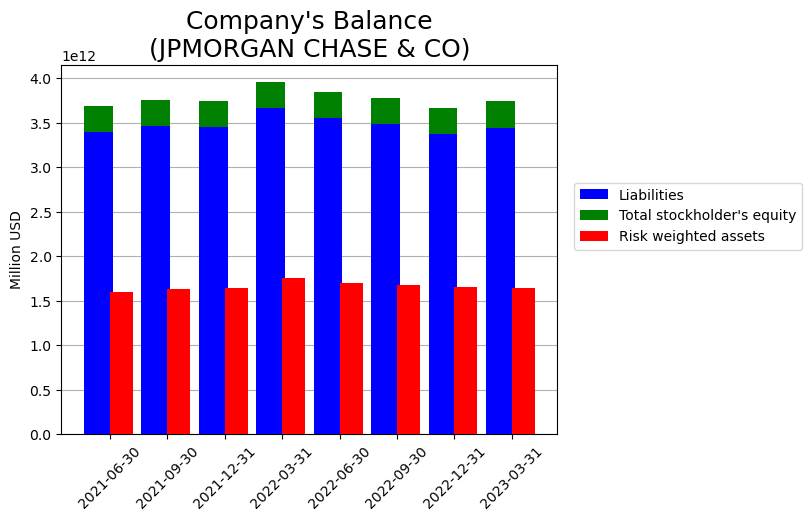

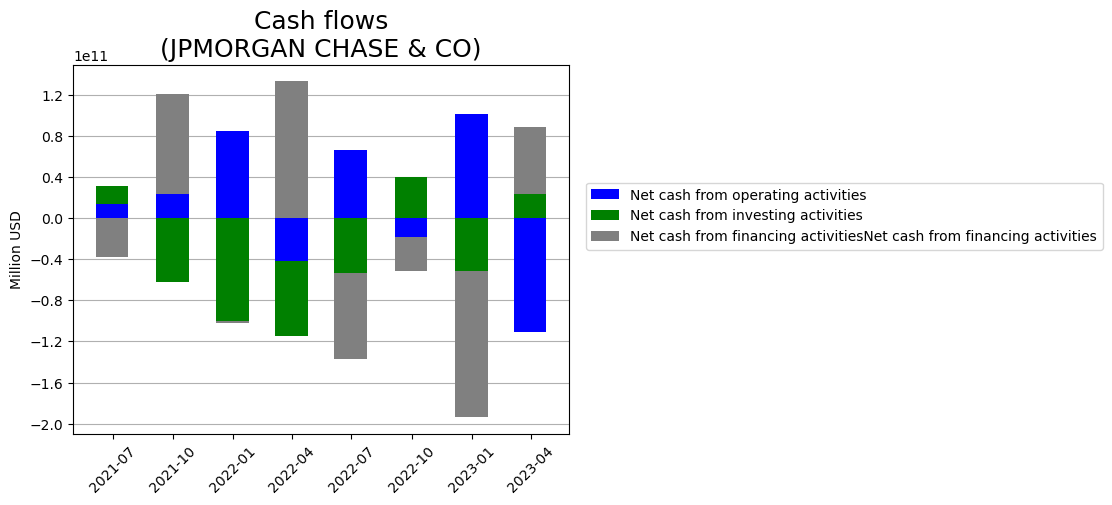

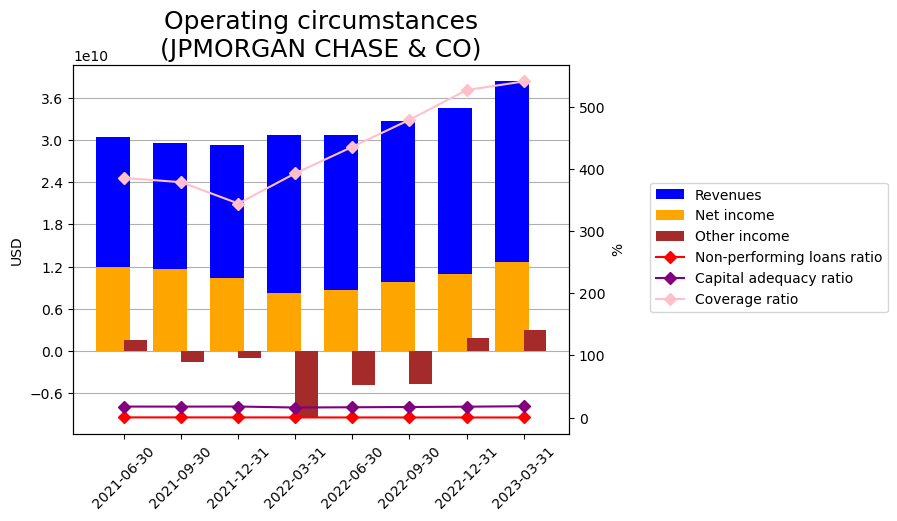

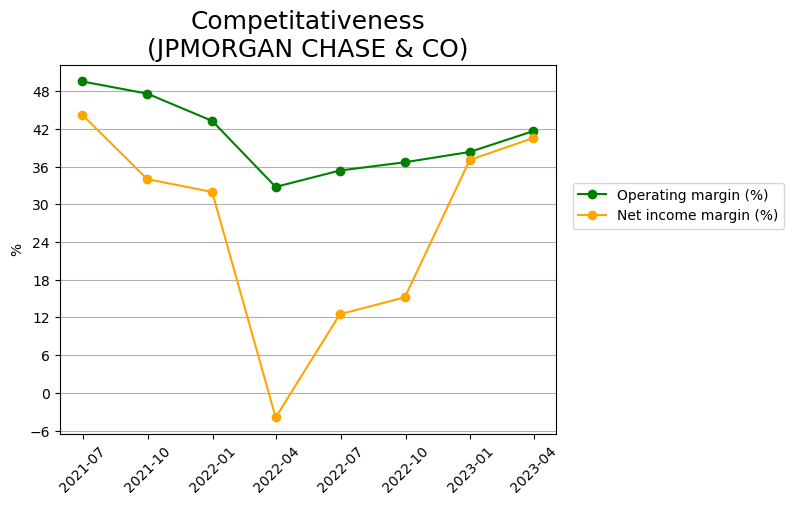

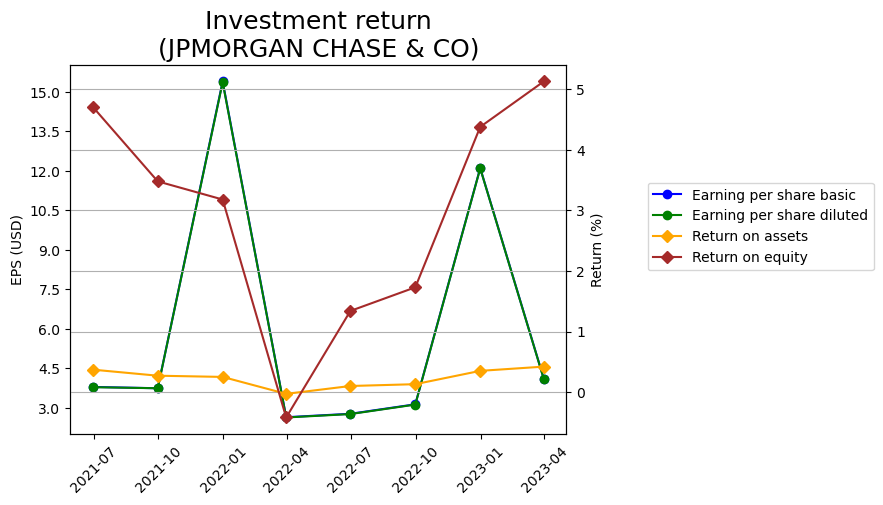

In [16]:
# Section 3: Plot 4 figures using seaborn package according to the above dataframe
def plot_data(result, industry_type, company_name):
    result = result.astype("float64", copy = True)
    #print(df.dtypes)
    
    if(industry_type == 'N'):
        print("Industry:", industry_type)
        # Figure 1: Liabilities and Stockholder's equity stacked barchart (summation is assets)
        fig1 = plt.subplot(111)
        fig1.yaxis.set_major_locator(MaxNLocator(10))  # Max number of labels in y axis

        x = list(result.columns)  # x labels (quarter date)
        #x = [1,2,3,4,5,6,7,8]

        Liabilities = result.loc['Liabilities', :]
        Equity = result.loc["Total stockholder's equity", :]
        #print(Liabilities)
        #print(Equity)

        plt.bar(x, Liabilities, color='blue',label='Liabilities', width=50, zorder=3)
        plt.bar(x,Equity,color='green',label="Total stockholder's equity", width=50, bottom=Liabilities, zorder=3)
        plt.title("Liabilities and Stockholder's equity\n(" + company_name + ")", fontsize=18)
        plt.xticks(rotation=45)
        plt.ylabel('USD')
        plt.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')
        plt.grid(axis='y')
        plt.show()





        # Figure 2: Cash flow stacked barchart
        fig2 = plt.subplot(111)
        fig2.yaxis.set_major_locator(MaxNLocator(10)) # Max number of labels in y axis
        operating =  result.loc['Net cash from operating activities', :]

        investing = result.loc['Net cash from investing activities', :]

        financing = result.loc['Net cash from financing activities', :]

        plt.bar(x, operating, color='blue', label='Net cash from operating activities', width=50, zorder=3)

        # Stack upward or downward depends on the sign of value. Downward for negative values
        # Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
        baseline = []



        # Setting baseline for stacking investing values
        for idx in range(len(result.columns)):
            if(investing[idx] < 0):
                if(operating[idx] < 0):
                    baseline.append(operating[idx]) 
                else:
                    baseline.append(0) 
            else:
                if(operating[idx] < 0):
                    baseline.append(0) 
                else:
                    baseline.append(operating[idx]) 


        plt.bar(x, investing, color='green',label='Net cash from investing activities', width=50, zorder=3, bottom=baseline)



        baseline2 = []
        for idx in range(len(result.columns)):

            # Same sign of investing value and financing value (++ or --)
            if(investing[idx]*financing[idx] >= 0):
                baseline2.append(investing[idx])

            # Different sign of investing and financing value (+- or -+)
            else:

                # Same sign of investing value and operating value (++ or --)
                if(operating[idx]*investing[idx] >= 0):
                    baseline2.append(0)
                    #print('second')

                # Different sign of investing and operating value (+- or -+)    
                else:
                    baseline2.append(operating[idx])
                    #print('third')
                    #print(operating[idx]*investing[idx])

        plt.bar(x, financing, color='gray', label='Net cash from financing activitiesNet cash from financing activities', width=50, zorder=3, bottom=baseline2)

        plt.title('Cash flows\n(' + company_name + ")", fontsize=18)
        plt.xticks(rotation=45)
        plt.ylabel('USD')
        plt.legend(bbox_to_anchor=(1.02, 0.7), loc='upper left')
        plt.grid(axis='y')
        plt.show()



        # Figure 3: Operating circumstance
        fig3 = plt.subplot(111)
        fig3.yaxis.set_major_locator(MaxNLocator(10)) # Max number of labels in y axis
        plt.xticks(rotation=45)  # Need to place this setting before plotting or interpreter will confuse

        revenue = result.loc['Revenue', :]
        gross_profit = result.loc['Gross profit', :]
        net_income = result.loc['Net income', :]
        other_income = result.loc['Comprehensive income net of tax', :] - result.loc['Net income', :]
        days_inventory = result.loc['Days Inventory (days)', :]

        x_temp = np.arange(len(x))

        br1 = plt.bar(x_temp - 0.2, revenue, color='blue',label='Revenues', width=0.6, zorder=2, alpha = 0.85)
        br2 = plt.bar(x_temp - 0.2, gross_profit, color='green',label='Gross profit', width=0.6, zorder=2, alpha = 0.85)
        br3 = plt.bar(x_temp - 0.2, net_income, color='orange',label='Net income', width=0.6, zorder=3, alpha = 0.85)
        br4 = plt.bar(x_temp + 0.2, other_income, color='brown',label='Other income', width=0.4, zorder=1, alpha = 0.85)



        # Double y axes
        fig3_1 = fig3.twinx()
        ln1 = fig3_1.plot(x_temp, days_inventory, color='red', marker='D',label='Days inventory')

        plt.xticks(x_temp, x)

        plt.title("Operating circumstances\n(" + company_name + ")", fontsize=18)

        #plt.ylabel('Million USD')


        fig3.set_ylabel('USD')
        fig3_1.set_ylabel('Days')

        #print(type(br1))

        #brs_lns = br1 + br2 + br3 + br4 + ln1
        #brs_lns = list(br1) + ln1
        brs_lns = [br1, br2, br3, br4] + ln1
        #labels = [bl.get_label() for bl in brs_lns]
        plt.legend(handles = brs_lns, bbox_to_anchor=(1.15,0.7), loc='upper left')
        #plt.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')

        plt.grid(axis='y')

        plt.show()



        # Figure 4: Competitiveness
        gross_margin = result.loc['Gross margin (%)', :]
        operating_margin = result.loc['Operating margin (%)', :]
        net_income_margin = result.loc['Net income margin (%)', :]


        fig4 = plt.subplot(111)
        fig4.yaxis.set_major_locator(MaxNLocator(10))

        fig4.plot(x,gross_margin,color='blue', marker='o',label='Gross margin (%)')
        fig4.plot(x,operating_margin,color='green', marker='o',label='Operating margin (%)')
        fig4.plot(x,net_income_margin,color='orange', marker='o',label='Net income margin (%)')

        fig4.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')
        fig4.grid(axis='y')
        plt.xticks(rotation=45)
        plt.title('Competitativeness\n(' + company_name + ')', fontsize=18)
        fig4.set_ylabel('%')
        plt.show()




        # Figure 5: Investment return
        fig5 = plt.subplot(111)
        fig5.yaxis.set_major_locator(MaxNLocator(10))
        plt.xticks(rotation=45)

        earning_per_share_basic = result.loc['Earning per share basic', :]
        earning_per_share_diluted = result.loc['Earning per share diluted', :]
        return_on_assets = result.loc['Return on assets (%)', :]
        return_on_equity = result.loc['Return on equity (%)', :]

        ln1 = plt.plot(x,earning_per_share_basic,color='blue', marker='o',label='Earning per share basic')
        ln2 = plt.plot(x,earning_per_share_diluted,color='green', marker='o',label='Earning per share diluted')


        # Double y axes
        fig5_1 = fig5.twinx()
        ln3 = fig5_1.plot(x, return_on_assets, color='orange', marker='D',label='Return on assets')
        ln4 = fig5_1.plot(x, return_on_equity, color='brown', marker='D',label='Return on equity')


        plt.title("Investment return\n(" + company_name + ")", fontsize=18)




        fig5.set_ylabel('EPS (USD)')
        fig5_1.set_ylabel('Return (%)')

        #print(type(br1))

        #brs_lns = br1 + br2 + br3 + br4 + ln1
        #brs_lns = list(br1) + ln1
        lns = ln1 + ln2 + ln3 + ln4
        #labels = [bl.get_label() for bl in brs_lns]
        plt.legend(handles = lns, bbox_to_anchor=(1.15,0.7), loc='upper left')
        #plt.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')

        plt.grid(axis='y')

        plt.show()
        
        
    elif(industry_type == 'F'):
        #print("Financial industry")
        
        # Figure 1: Liabilities and Stockholder's equity stacked barchart (summation is assets)
        fig1 = plt.subplot(111)
        fig1.yaxis.set_major_locator(MaxNLocator(10))  # Max number of labels in y axis

        x = list(result.columns)  # x labels (quarter date)
        x_temp = np.arange(len(x))  # For bar chart's offset
        #x = [1,2,3,4,5,6,7,8]

        Liabilities = result.loc['Liabilities', :]
        Equity = result.loc["Total stockholder's equity", :]
        Investment = result.loc["Total investment", :]
        #Investment = pd.Series([1000000] * 8, dtype = "float64")
        Risk_Weighted_Assets = result.loc["Risk weighted assets", :]
        #Risk_Weighted_Assets = pd.Series([np.nan] * 8, dtype = "float64")

        plt.bar(x_temp - 0.2, Liabilities, color='blue',label='Liabilities', width=0.5, zorder=3)
        plt.bar(x_temp - 0.2, Equity,color='green',label="Total stockholder's equity", width=0.5, bottom=Liabilities, zorder=3)
        plt.bar(x_temp, Investment, color='orange',label="Total investment", width=0.5, zorder=3) if (not Investment.isna().all()) else None
        plt.bar(x_temp + 0.2, Risk_Weighted_Assets,color='red',label="Risk weighted assets", width=0.4, zorder=3) if (not Risk_Weighted_Assets.isna().all()) else None
        plt.xticks(x_temp, x)
        
        plt.title("Company's Balance\n(" + company_name + ")", fontsize=18)
        plt.xticks(rotation=45)
        plt.ylabel('Million USD')
        plt.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')
        plt.grid(axis='y')
        plt.show()
        
#         # Figure 2: Loans composition (if having loans)
#         Total_loans = result.loc['Total loans', :]
#         if (not Total_loans.isna().all()):
#             fig2 = plt.subplot(111)
#             fig2.yaxis.set_major_locator(MaxNLocator(10))  # Max number of labels in y axis
            
#             Allowance_for_loans_and_lease_losses = result.loc['Allowance for loan and lease losses', :]
#             Nonperforming_loans = result.loc['Non-performing loans', :]
#             Performing_loans = Total_loans + Allowance_for_loans_and_lease_losses - Nonperforming_loans
            
#             plt.bar(x, Performing_loans, color='blue',label='Performing loans', width=60, zorder=3) if (not Performing_loans.isna().all()) else None
#             plt.bar(x, Nonperforming_loans,color='green',label="Non-performing loans", width=60, bottom=Performing_loans, zorder=3) if (not Nonperforming_loans.isna().all()) else None
#             plt.bar(x, -Allowance_for_loans_and_lease_losses, color='orange',label="Allowance for loan and lease losses", width=60, zorder=3) if (not Allowance_for_loans_and_lease_losses.isna().all()) else None
            
#             plt.title("Loans' composition\n(" + company_name + ")", fontsize=18)
#             plt.xticks(rotation=45)
#             plt.ylabel('Million USD')
#             plt.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')
#             plt.grid(axis='y')
#             plt.show()
            
#         else:
#             pass
        
        
        # Figure 2: Cash flow stacked barchart
        fig2 = plt.subplot(111)
        fig2.yaxis.set_major_locator(MaxNLocator(10)) # Max number of labels in y axis
        operating =  result.loc['Net cash from operating activities', :]

        investing = result.loc['Net cash from investing activities', :]

        financing = result.loc['Net cash from financing activities', :]

        plt.bar(x, operating, color='blue', label='Net cash from operating activities', width=50, zorder=3)

        # Stack upward or downward depends on the sign of value. Downward for negative values
        # Reference: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html
        baseline = []



        # Setting baseline for stacking investing values
        for idx in range(len(result.columns)):
            if(investing[idx] < 0):
                if(operating[idx] < 0):
                    baseline.append(operating[idx]) 
                else:
                    baseline.append(0) 
            else:
                if(operating[idx] < 0):
                    baseline.append(0) 
                else:
                    baseline.append(operating[idx]) 


        plt.bar(x, investing, color='green',label='Net cash from investing activities', width=50, zorder=3, bottom=baseline)

        baseline2 = []
        for idx in range(len(result.columns)):

            # Same sign of investing value and financing value (++ or --)
            if(investing[idx]*financing[idx] >= 0):
                baseline2.append(investing[idx])

            # Different sign of investing and financing value (+- or -+)
            else:

                # Same sign of investing value and operating value (++ or --)
                if(operating[idx]*investing[idx] >= 0):
                    baseline2.append(0)
                    #print('second')

                # Different sign of investing and operating value (+- or -+)    
                else:
                    baseline2.append(operating[idx])
                    #print('third')
                    #print(operating[idx]*investing[idx])

        plt.bar(x, financing, color='gray', label='Net cash from financing activitiesNet cash from financing activities', width=50, zorder=3, bottom=baseline2)

        plt.title('Cash flows\n(' + company_name + ")", fontsize=18)
        plt.xticks(rotation=45)
        plt.ylabel('Million USD')
        plt.legend(bbox_to_anchor=(1.02, 0.7), loc='upper left')
        plt.grid(axis='y')
        plt.show()
        
        
        # Figure 3: Operating circumstance
        fig3 = plt.subplot(111)
        fig3.yaxis.set_major_locator(MaxNLocator(10)) # Max number of labels in y axis
        plt.xticks(rotation=45)  # Need to place this setting before plotting or interpreter will confuse
        plt.grid(True, axis='y', zorder = 0)

        revenue = result.loc['Revenue', :]
        gross_profit = result.loc['Gross Profit', :]
        net_income = result.loc['Net income', :]
        other_income = result.loc['Comprehensive income net of tax', :] - result.loc['Net income', :]
        
        nonperforming_loans_ratio = result.loc["Non-performing loans ratio (%)", :]
        capital_adequacy_ratio = result.loc["Capital adequacy ratio (%)", :]
        coverage_ratio = result.loc["Coverage ratio (%)", :]

        x_temp = np.arange(len(x))

        br1 = plt.bar(x_temp - 0.2, revenue, color='blue',label='Revenues', width=0.6, zorder=3)
        br2 = plt.bar(x_temp - 0.2, gross_profit, color='green',label='Gross profit', width=0.6, zorder=3)  if (not gross_profit.isna().all()) else None
        br3 = plt.bar(x_temp - 0.2, net_income, color='orange',label='Net income', width=0.6, zorder=3, alpha = 1)
        br4 = plt.bar(x_temp + 0.2, other_income, color='brown',label='Other income', width=0.4, zorder=3, alpha = 1)



        # Double y axes
        fig3_1 = fig3.twinx()
        ln1 = fig3_1.plot(x_temp, nonperforming_loans_ratio, color='red', marker='D',label='Non-performing loans ratio') if (not nonperforming_loans_ratio.isna().all()) else None
        ln2 = fig3_1.plot(x_temp, capital_adequacy_ratio, color='purple', marker='D',label='Capital adequacy ratio') if (not capital_adequacy_ratio.isna().all()) else None
        ln3 = fig3_1.plot(x_temp, coverage_ratio, color='pink', marker='D',label='Coverage ratio') if (not coverage_ratio.isna().all()) else None
        #ln3 = None (for test)
        
        plt.xticks(x_temp, x)

        plt.title("Operating circumstances\n(" + company_name + ")", fontsize=18)

        #plt.ylabel('Million USD')


        fig3.set_ylabel('USD')
        fig3_1.set_ylabel('%')

        #print(type(br1))

        #brs_lns = br1 + br2 + br3 + br4 + ln1
        #brs_lns = list(br1) + ln1
        brs_lns = [br1, br3, br4] + (ln1 if ln1 else []) + (ln2 if ln2 else []) + (ln3 if ln3 else [])
        if br2:
            brs_lns.append(br2)
        else:
            pass
        #labels = [bl.get_label() for bl in brs_lns]
        plt.legend(handles = brs_lns, bbox_to_anchor=(1.15,0.7), loc='upper left')
        #plt.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')

        plt.show()
        
        
        
        # Figure 4: Competitiveness
        gross_margin = result.loc["Gross margin (%)", :]
        operating_margin = result.loc['Operating margin (%)', :]
        net_income_margin = result.loc['Net income margin (%)', :]


        fig4 = plt.subplot(111)
        fig4.yaxis.set_major_locator(MaxNLocator(10))

        fig4.plot(x,gross_margin,color='blue', marker='o',label='Gross margin (%)') if (not gross_margin.isna().all()) else None
        fig4.plot(x,operating_margin,color='green', marker='o',label='Operating margin (%)')
        fig4.plot(x,net_income_margin,color='orange', marker='o',label='Net income margin (%)')

        fig4.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')
        fig4.grid(axis='y')
        plt.xticks(rotation=45)
        plt.title('Competitativeness\n(' + company_name + ')', fontsize=18)
        fig4.set_ylabel('%')
        plt.show()
        
        
        
        # Figure 5: Investment return
        fig5 = plt.subplot(111)
        fig5.yaxis.set_major_locator(MaxNLocator(10))
        plt.xticks(rotation=45)

        earning_per_share_basic = result.loc['Earning per share basic', :]
        earning_per_share_diluted = result.loc['Earning per share diluted', :]
        return_on_assets = result.loc['Return on assets (%)', :]
        return_on_equity = result.loc['Return on equity (%)', :]

        ln1 = plt.plot(x,earning_per_share_basic,color='blue', marker='o',label='Earning per share basic')
        ln2 = plt.plot(x,earning_per_share_diluted,color='green', marker='o',label='Earning per share diluted')


        # Double y axes
        fig5_1 = fig5.twinx()
        ln3 = fig5_1.plot(x, return_on_assets, color='orange', marker='D',label='Return on assets')
        ln4 = fig5_1.plot(x, return_on_equity, color='brown', marker='D',label='Return on equity')


        plt.title("Investment return\n(" + company_name + ")", fontsize=18)




        fig5.set_ylabel('EPS (USD)')
        fig5_1.set_ylabel('Return (%)')

        #print(type(br1))

        #brs_lns = br1 + br2 + br3 + br4 + ln1
        #brs_lns = list(br1) + ln1
        lns = ln1 + ln2 + ln3 + ln4
        #labels = [bl.get_label() for bl in brs_lns]
        plt.legend(handles = lns, bbox_to_anchor=(1.15,0.7), loc='upper left')
        #plt.legend(bbox_to_anchor=(1.02,0.7), loc='upper left')

        plt.grid(axis='y')

        plt.show()
        
    else:
        print("Unknown industry type")
    
plot_data(result, industry_type, company_name)

## Some test below

In [20]:
res = reports[0].find("ix:nonnumeric", {"id" : re.compile(r"fact-identifier-23")})
print(type(res))
print(res)

<class 'bs4.element.Tag'>
<ix:nonnumeric contextref="i02c0f3e92d75432fbe3c6a24022bf7b0_D20200927-20210327" continued-taxonomy="false" data-original-id="id3VybDovL2RvY3MudjEvZG9jOmRhZDhkZWU5YWJlYTQ1NDM4YTBlMDI0ZmZiODE1ZDFhL3NlYzpkYWQ4ZGVlOWFiZWE0NTQzOGEwZTAyNGZmYjgxNWQxYV8xL2ZyYWc6NDJhYzk4NTk4NDNhNDY1YjgwOGU5ZDQ1MTliZGFiZDUvdGV4dHJlZ2lvbjo0MmFjOTg1OTg0M2E0NjViODA4ZTlkNDUxOWJkYWJkNV8yMTQ1_b4ea6b9e-486e-4c6c-8b88-765989412774" enabled-taxonomy="true" highlight-taxonomy="false" hover-taxonomy="false" id="fact-identifier-23" inside-table="false" isadditionalitemsonly="false" isamountsonly="false" iscalculationsonly="false" iscustomonly="false" isnegativesonly="false" isstandardonly="true" istextonly="true" name="dei:DocumentType" onclick="Taxonomies.clickEvent(event, this)" onkeyup="Taxonomies.clickEvent(event, this)" onmouseenter="Taxonomies.enterElement(event, this);" onmouseleave="Taxonomies.leaveElement(event, this);" selected-taxonomy="false" tabindex="18">10-Q</ix:nonnumeric>


In [61]:
other_income

NameError: name 'other_income' is not defined

In [26]:
from dateutil import parser 
time = parser.parse("20230331")
print(type(time))

time2 = parser.parse("20230331")
print(time2)

<class 'datetime.datetime'>
2023-03-31 00:00:00


In [12]:
# Python's switch-case pattern. No need to break.

x = 11
match x:
    case 1:
        print("Case 1")
    case 2:
        print("Case 2")
    case 10:
        print("Case 3")
    case _:
        print("Else")

Else


In [178]:
float(9.8)

9.8